# 01 — Preprocessing & EDA (Beijing Multi-Site Air Quality)
Mục tiêu: tải dữ liệu, làm sạch, tạo nhãn phân lớp (AQI class theo PM2.5 24h mean), tạo đặc trưng thời gian + lag, và lưu `data/processed/cleaned.parquet`.

**Lưu ý:** nếu `USE_UCIMLREPO=True` thì notebook cần internet để tải dataset từ UCI.

In [1]:
USE_UCIMLREPO = False
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"

OUTPUT_CLEANED_PATH = 'data/processed/cleaned.parquet'
LAG_HOURS=[1, 3, 24]


In [2]:
# Parameters
USE_UCIMLREPO = False
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"
OUTPUT_CLEANED_PATH = "data/processed/cleaned.parquet"
LAG_HOURS = [1, 3, 24]


In [3]:
from pathlib import Path
import pandas as pd
import numpy as np

from src.classification_library import (
    load_beijing_air_quality,
    clean_air_quality_df,
    add_pm25_24h_and_label,
    add_time_features,
    add_lag_features,
)

PROJECT_ROOT = Path('..').resolve()
OUT_PATH = (PROJECT_ROOT / OUTPUT_CLEANED_PATH).resolve()
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)


In [4]:
df_raw = load_beijing_air_quality(use_ucimlrepo=USE_UCIMLREPO, raw_zip_path=RAW_ZIP_PATH)
print('raw shape:', df_raw.shape)
df_raw.head()

raw shape: (420768, 18)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [5]:
df = clean_air_quality_df(df_raw)
df = add_pm25_24h_and_label(df)
df = add_time_features(df)
df = add_lag_features(df, lag_hours=LAG_HOURS)
print('cleaned shape:', df.shape)
df[['datetime','station','PM2.5','pm25_24h','aqi_class']].head(10)

cleaned shape: (420768, 55)


,datetime,station,PM2.5,pm25_24h,aqi_class
0,2013-03-01 00:00:00,Aotizhongxin,4.0,NaN,NaN
1,2013-03-01 01:00:00,Aotizhongxin,8.0,NaN,NaN
2,2013-03-01 02:00:00,Aotizhongxin,7.0,NaN,NaN
3,2013-03-01 03:00:00,Aotizhongxin,6.0,NaN,NaN
4,2013-03-01 04:00:00,Aotizhongxin,3.0,NaN,NaN
5,2013-03-01 05:00:00,Aotizhongxin,5.0,NaN,NaN
6,2013-03-01 06:00:00,Aotizhongxin,3.0,NaN,NaN
7,2013-03-01 07:00:00,Aotizhongxin,3.0,NaN,NaN
8,2013-03-01 08:00:00,Aotizhongxin,3.0,NaN,NaN
9,2013-03-01 09:00:00,Aotizhongxin,3.0,NaN,NaN


In [6]:
# EDA nhanh: missingness và phân bố lớp
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_rate.head(20)

CO_lag24      0.049849
CO_lag3       0.049284
CO_lag1       0.049227
CO            0.049198
O3_lag24      0.032203
O3_lag3       0.031640
O3_lag1       0.031583
O3            0.031554
NO2_lag24     0.029446
NO2_lag3      0.028881
NO2_lag1      0.028823
NO2           0.028795
SO2_lag24     0.022091
SO2_lag3      0.021525
SO2_lag1      0.021468
SO2           0.021439
PM2.5         0.020769
aqi_class     0.018616
pm25_24h      0.018616
PM10_lag24    0.015990
dtype: float64

In [7]:
# Kiểm tra khoảng thời gian và tính liên tục
start_date = df['datetime'].min()
end_date = df['datetime'].max()
total_hours = (end_date - start_date).total_seconds() / 3600 + 1

print(f"Khoảng thời gian: {start_date} đến {end_date}")
print(f"Số giờ dự kiến: {total_hours}")
print(f"Số dòng thực tế mỗi trạm: {len(df)/df['station'].nunique()}")

# Giải thích: PM2.5 là biến quan trọng nhất nhưng có tỷ lệ thiếu (~2.08%). 
# Nếu thiếu tập trung vào các đợt cao điểm, dự báo sẽ mất chính xác.

Khoảng thời gian: 2013-03-01 00:00:00 đến 2017-02-28 23:00:00
Số giờ dự kiến: 35064.0
Số dòng thực tế mỗi trạm: 35064.0


In [8]:
class_dist = df['aqi_class'].value_counts(dropna=False)
class_dist

aqi_class
Unhealthy                         148558
Moderate                          109549
Unhealthy_for_Sensitive_Groups     64731
Very_Unhealthy                     56242
Hazardous                          19931
Good                               13924
NaN                                 7833
Name: count, dtype: int64

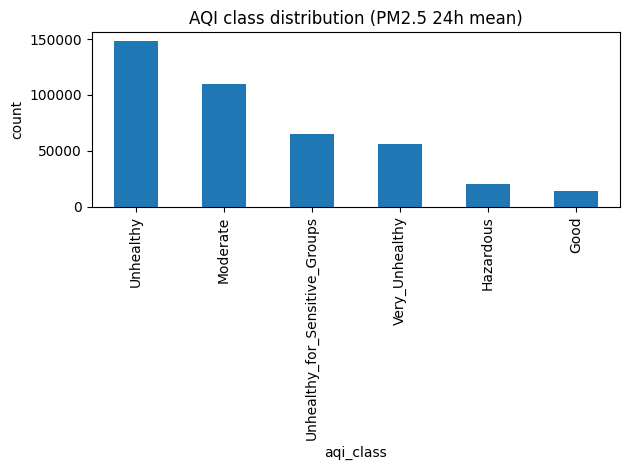

In [9]:
import matplotlib.pyplot as plt

class_dist.drop(index=[x for x in class_dist.index if pd.isna(x)], errors='ignore').plot(kind='bar')
plt.title('AQI class distribution (PM2.5 24h mean)')
plt.ylabel('count')
plt.tight_layout()
plt.show()

In [10]:
df.to_parquet(OUT_PATH, index=False)
print('Saved:', OUT_PATH)

Saved: C:\Users\Speedyservice\data\processed\cleaned.parquet


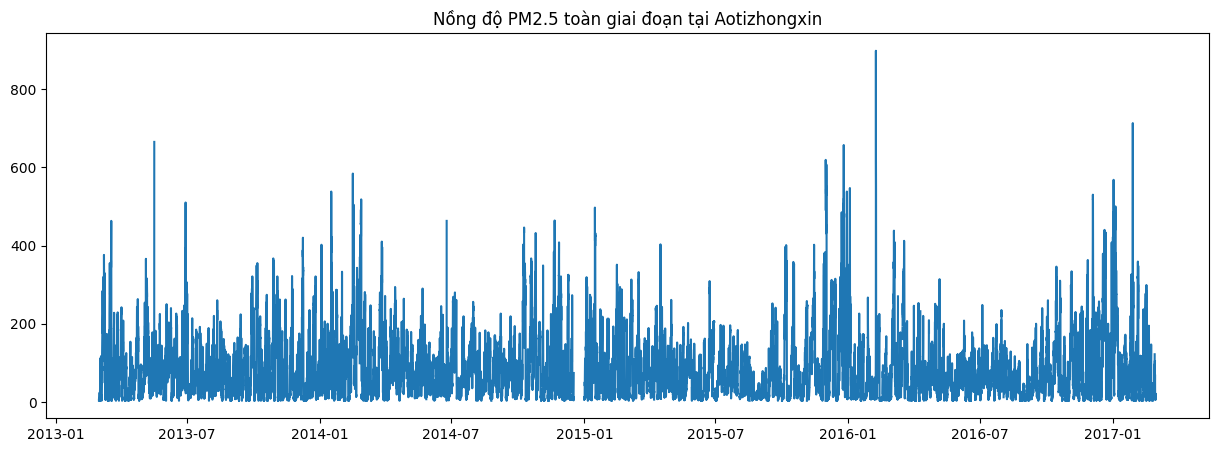

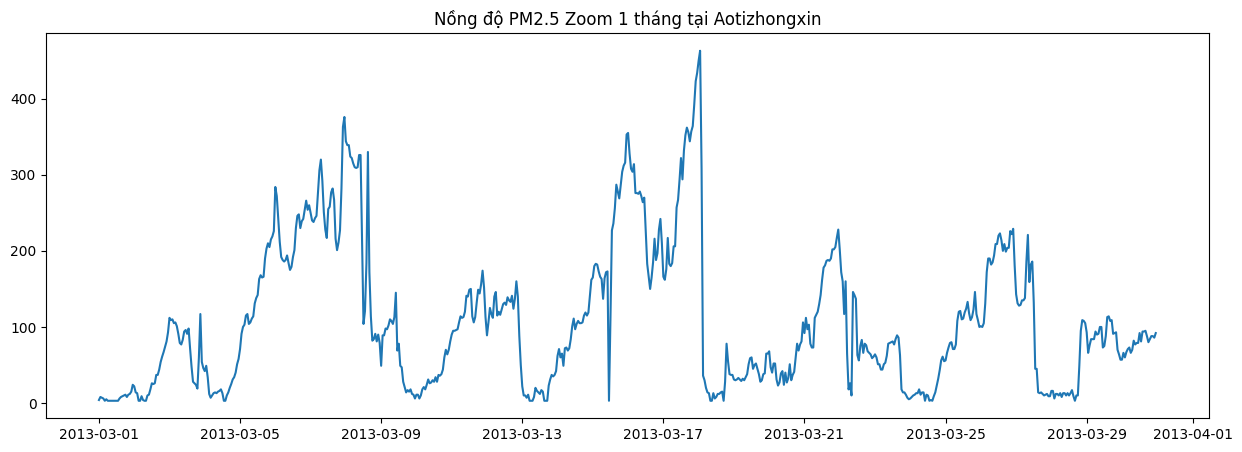

In [11]:
import matplotlib.pyplot as plt

# Chọn 1 trạm để phân tích (ví dụ: Aotizhongxin)
station_name = 'Aotizhongxin'
df_station = df[df['station'] == station_name].set_index('datetime')

# Hình 1: PM2.5 toàn giai đoạn
plt.figure(figsize=(15, 5))
plt.plot(df_station['PM2.5'])
# Xóa bỏ phần  đi
plt.title(f'Nồng độ PM2.5 toàn giai đoạn tại {station_name}')
plt.show()

# Hình 2: Zoom 1 tháng để thấy tính chu kỳ (Seasonality)
plt.figure(figsize=(15, 5))
plt.plot(df_station['PM2.5'].iloc[:720]) # 720 giờ ~ 1 tháng
plt.title(f'Nồng độ PM2.5 Zoom 1 tháng tại {station_name}')
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller, kpss
# Loại bỏ giá trị NaN trước khi kiểm định
series = df_station['PM2.5'].dropna()

# Kiểm định ADF
adf_result = adfuller(series)
print(f'ADF p-value: {adf_result[1]}') # Nếu < 0.05 => Chuỗi dừng [cite: 88, 211]

# Kiểm định KPSS
kpss_result = kpss(series)
print(f'KPSS p-value: {kpss_result[1]}') # Nếu > 0.05 => Chuỗi dừng [cite: 89, 211]

ADF p-value: 0.0
KPSS p-value: 0.1


C:\Users\Speedyservice\AppData\Local\Temp\ipykernel_17116\2237605643.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series)


<Figure size 1200x500 with 0 Axes>

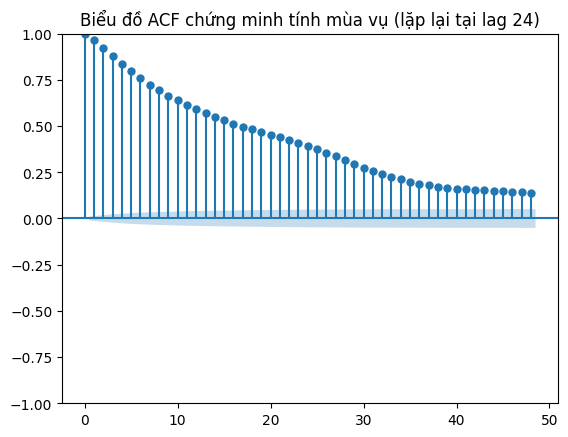

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Vẽ ACF để chứng minh tính mùa vụ s=24
plt.figure(figsize=(12, 5))
plot_acf(series, lags=48) # Xem trong 48 giờ
plt.title('Biểu đồ ACF chứng minh tính mùa vụ (lặp lại tại lag 24)')
plt.show()